In [1]:
import imgtda
from imgtda import locally_striped as ls
from imgtda.locally_striped import defect_analysis as da

import numpy as np
import pandas as pd
from scipy import misc
from matplotlib import pyplot as plt
from scipy import stats

%matplotlib inline

## Set Up Project

In [2]:
myproject = imgtda.Project

myproject['directory'] = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast'
myproject['bmp_format'] = 'g21flow/bmps/%06d.bmp'
myproject['pd_sub_format'] = 'g21flow/pd_sub/%06d.csv'
myproject['pd_sup_format'] = 'g21flow/pd_sup/%06d.csv'
myproject['additional_data'] = {'lyap_format':'g21per/bmps_abs_val/%05d.bmp',
                                'delta':40}


## Utility Functions

In [3]:
def load_image_data(project, idx):
    
    im = ls.image.load_image_from_file(project['directory'] + "/" + (project['bmp_format'] % idx))
    im.load_sublevel_pd(project['directory'] + "/" + (project['pd_sub_format'] % idx))
    im.load_superlevel_pd(project['directory'] + "/" + (project['pd_sup_format'] % idx))
    
    return im

def load_lyap_data(project, idx):
    
    lyap = misc.imread(project['directory'] + "/" + (project['additional_data']['lyap_format'] % idx))
    
    return lyap

def cropping_region():
    # Plot the results
    # Crop the temperature field to a circle first.
    c = np.zeros((421,421))
    centerx = 210
    centery = 210
    radius=200
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            if ((i-centerx)**2 + (j-centery)**2 < radius**2):
                c[i,j] = 1
    c = c.astype(np.int)

    return c

## The Code

In [4]:
def fill_smoothing_weights(idx_range, smoothing_window):
    
    weights = {}

    for defect_type in da.DEFECT_TYPES:
        weights[defect_type] = []
    weights['unclassified'] = []
    weights['defect-free'] = []
    
    for idx in idx_range:
        im = get_image_defects(idx, sigma, radius)

        weights = append_smoothing_weight(im, weights, smoothing_window)

    return weights

def append_smoothing_weight(im, weights, smoothing_window):
    
    for defect_type in da.DEFECT_TYPES:
        weights[defect_type].append(im.defect_regions[defect_type]/float(smoothing_window))
    weights['unclassified'].append(im.unclassified_defect_region/float(smoothing_window))
    weights['defect-free'].append(im.defect_free_region/float(smoothing_window))

    return weights

def pop_smoothing_weight(weights):
    
    for defect_type in da.DEFECT_TYPES:
        weights[defect_type].pop(0)
    weights['unclassified'].pop(0)
    weights['defect-free'].pop(0)

    return weights

def get_sum_of_weights(weights):
    
    sum_of_weights = {}
    
    for defect_type in da.DEFECT_TYPES:
        sum_of_weights[defect_type] = np.asarray([sum(i) for i in zip(*weights[defect_type])])
    sum_of_weights['unclassified'] = np.asarray([sum(i) for i in zip(*weights['unclassified'])])
    sum_of_weights['defect-free'] = np.asarray([sum(i) for i in zip(*weights['defect-free'])])
    
    return sum_of_weights

def get_image_defects(idx, sigma, radius):

    im = load_image_data(myproject, idx)
    im.generate_orientation_field(sigma,1)
    im.get_persistent_h1_generators(myproject['additional_data']['delta'])
    im.classify_defects(sigma,radius,'serial')

    return im

def plot_image_defects(im):
    
    c = cropping_region()

    print_bmp = im.bmp.copy()
    print_bmp[c==0] = 0
    fig = da.plot_defect_classifications(print_bmp, 
                                   im.all_defects, 
                                   im.unclassified_defect_region, 
                                   im.orientation_fields[sigma].topological_defects, 
                                   im.defect_free_region);
    return fig

def get_image_defect_stats(im):
    
    image_defect_stats = {}
    
    for defect_type in da.DEFECT_TYPES:
        image_defect_stats[defect_type] = 0
    
    for defect in im.all_defects:
        image_defect_stats[defect['defect_type']] = image_defect_stats[defect['defect_type']] + 1
        
    return image_defect_stats


def get_lyapunov_stats(idx, im, lyap, lyap_cutoff, sum_of_weights):
    
    lyap_thresholded = np.multiply((lyap >= lyap_cutoff).astype(np.float), lyap.astype(np.float))
    lyap_thresholded = lyap_thresholded/255. # Normalize
    
    lyap_integrals = {}
    
    for defect_type in da.DEFECT_TYPES:
        lyap_integrals[defect_type] = sum(sum(np.multiply(lyap_thresholded, sum_of_weights[defect_type])))
    
    lyap_integrals['unclassified'] = sum(sum(np.multiply(lyap_thresholded, sum_of_weights['unclassified'])))
    lyap_integrals['defect-free'] = sum(sum(np.multiply(lyap_thresholded, sum_of_weights['defect-free'])))
    
    return lyap_integrals



## Classify a single image

In [ ]:
idx = 100
sigma = 3
radius = 10


im = get_image_defects(idx, sigma, radius)
image_defect_stats = get_image_defect_stats(im)

plt.imshow(im.bmp)
plt.colorbar()
plt.show()

plot_image_defects(im)
plt.show()


## Process Images

In [5]:
from pprint import pprint as pp

sigma = 3
radius = 10
lyap_cutoffs = [0.2, 0.5, 0.8]

plot_the_things = 0

process_range = range(100, 3500)
smoothing_windows = [1, 10]

weights = {}
for window in smoothing_windows:
    print window
    weights[window] = fill_smoothing_weights(range(process_range[0] - window + 1, process_range[0]), window)

all_lyap_stats = {}
for lyap_cutoff in lyap_cutoffs:
    all_lyap_stats[lyap_cutoff] = {}
    for window in smoothing_windows:
        all_lyap_stats[lyap_cutoff][window] = {}
        for defect_type in da.DEFECT_TYPES:
            all_lyap_stats[lyap_cutoff][window][defect_type] = []
        all_lyap_stats[lyap_cutoff][window]['unclassified'] = []
        all_lyap_stats[lyap_cutoff][window]['defect-free'] = []

for idx in process_range:
    
    if idx % 50 == 0:
        print idx
    
    im = get_image_defects(idx, sigma, radius)
    image_defect_stats = get_image_defect_stats(im)
    
    if plot_the_things:
        plt.imshow(im.bmp)
        plt.colorbar()
        plt.show()
        
        plot_image_defects(im)
        plt.show()
        
        plt.set_cmap('jet');
        plt.rcParams['figure.figsize'] = (5.0, 5.0);
    
    lyap = load_lyap_data(myproject, idx)
    c = cropping_region()
    lyap[c==0] = 0
    
    lyap_thresholded = {}
    for lyap_cutoff in lyap_cutoffs:
        lyap_thresholded[lyap_cutoff] = (lyap >= lyap_cutoff*255.).astype(np.float)

    # Get the integral statistics
    sum_of_weights = {}
    for window in smoothing_windows:
        
        if plot_the_things:
            print "Window %d:" % window
        
        # Compute new weight arrays
        weights[window] = append_smoothing_weight(im, weights[window], window)
        
        sum_of_weights[window] = get_sum_of_weights(weights[window])

        for lyap_cutoff in lyap_cutoffs:
            lyap_stats = get_lyapunov_stats(idx, im, lyap, lyap_cutoff*255., sum_of_weights[window])

            for defect_type in da.DEFECT_TYPES:
                all_lyap_stats[lyap_cutoff][window][defect_type].append(lyap_stats[defect_type])
                if plot_the_things:
                    plt.imshow(sum_of_weights[window][defect_type])
                    plt.colorbar()
                    plt.show()
            all_lyap_stats[lyap_cutoff][window]['unclassified'].append(lyap_stats['unclassified'])
            all_lyap_stats[lyap_cutoff][window]['defect-free'].append(lyap_stats['defect-free'])

            if plot_the_things:
                plt.imshow(sum_of_weights[window]['unclassified'])
                plt.colorbar()
                plt.show()
                plt.imshow(sum_of_weights[window]['defect-free'])
                plt.colorbar()
                plt.show()


            if plot_the_things:
                plt.imshow(np.multiply(lyap/255., lyap_thresholded[lyap_cutoff]))
                plt.colorbar()
                plt.show()

                plt.imshow(np.multiply(sum_of_weights[window]['defect-free'], np.multiply(lyap/255., lyap_thresholded[lyap_cutoff])))
                plt.colorbar()
                plt.show()
                print "Sum of these values: %0.4f" % sum(sum(np.multiply(sum_of_weights[window]['defect-free'], np.multiply(lyap/255., lyap_thresholded[lyap_cutoff]))))


        # Pop the first weight arrays off the list to make room for the new one
        weights[window] = pop_smoothing_weight(weights[window])

    if plot_the_things:
        print ""
        print "PROCESSING INDEX %d:" % (idx)
        print "Defect counts: "
        pp(image_defect_stats)
        print "Lyapunov integrals: "
        pp(all_lyap_stats)



1
10
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450


/Users/birdbrain/anaconda/lib/python2.7/site-packages/imgtda/core/image.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  persistence_h1_gens[h1gens['row'], h1gens['col']] = 1


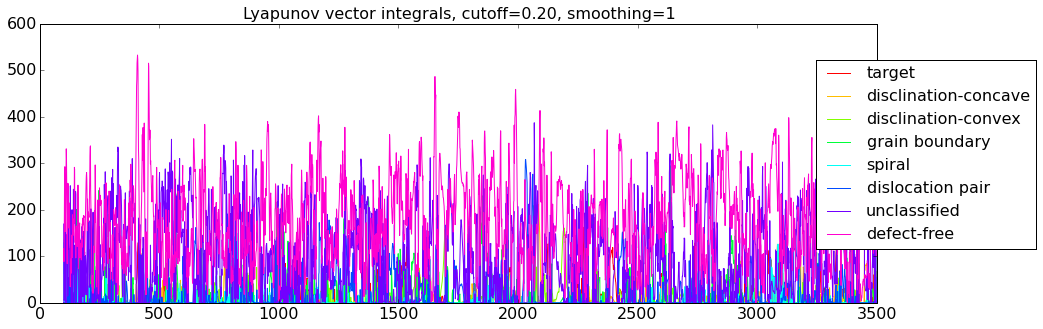

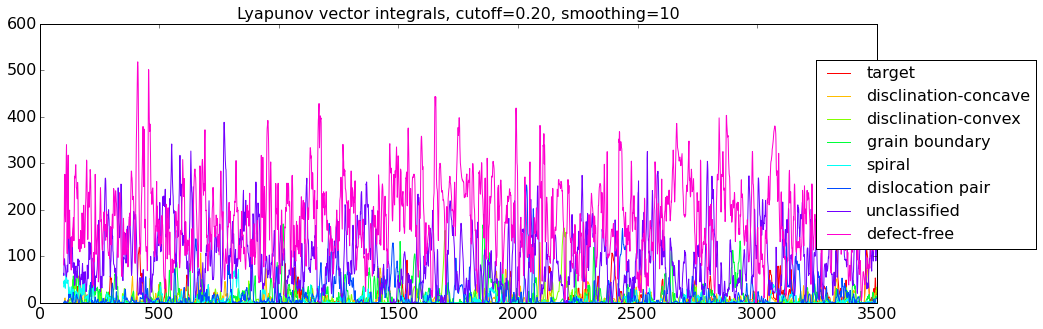

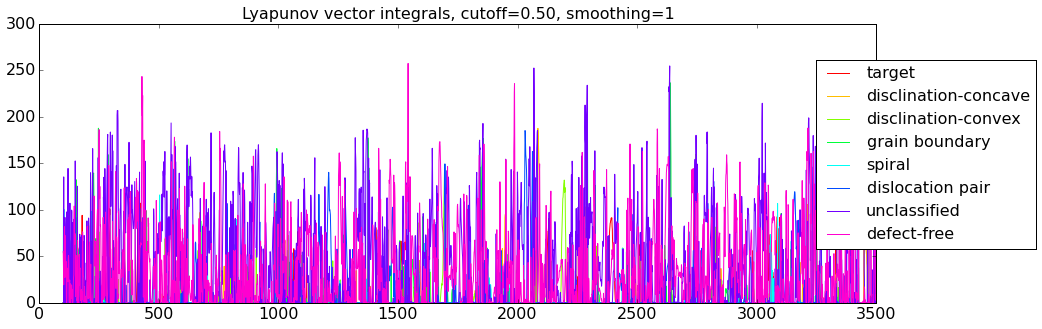

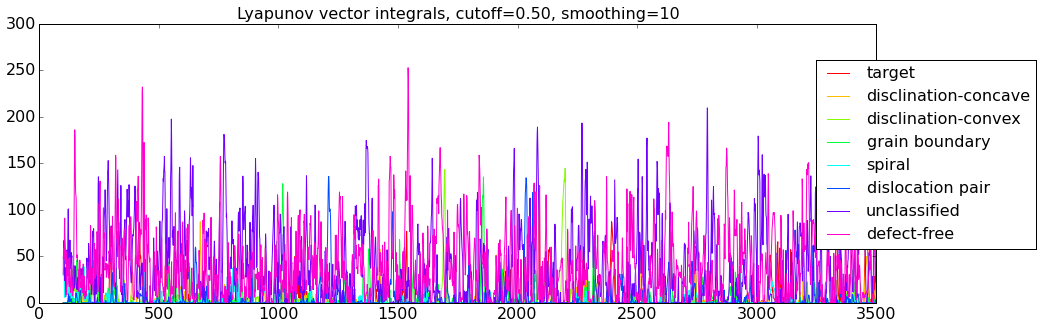

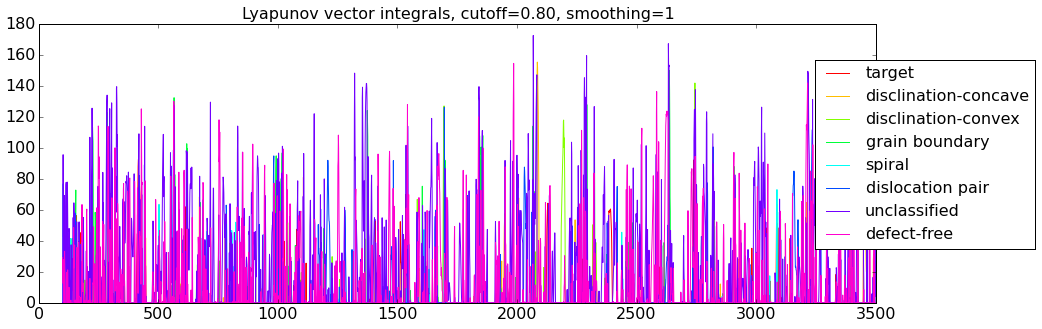

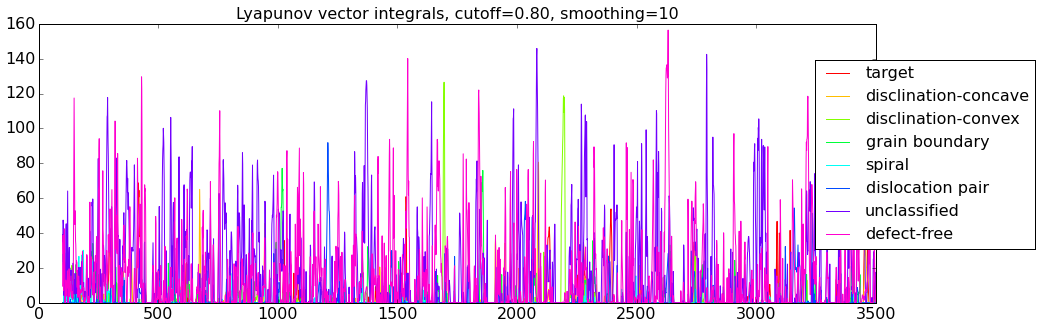

In [6]:
# Generate time series plots of integrals

plt.rcParams['figure.figsize'] = (15.0, 5.0);

NUM_COLORS = 8

cm = plt.get_cmap('hsv')

for lyap_cutoff in lyap_cutoffs:
    for window in smoothing_windows:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

        for defect_type in da.DEFECT_TYPES:
            ax.plot(process_range, all_lyap_stats[lyap_cutoff][window][defect_type], label=defect_type)
        ax.plot(process_range, all_lyap_stats[lyap_cutoff][window]['unclassified'], label='unclassified')
        ax.plot(process_range, all_lyap_stats[lyap_cutoff][window]['defect-free'], label='defect-free')
        plt.setp(ax.get_xticklabels(), fontsize=16)
        plt.setp(ax.get_yticklabels(), fontsize=16)
        ax.legend(fontsize=16, bbox_to_anchor=(1.2, 0.9))
        plt.title('Lyapunov vector integrals, cutoff=%0.2f, smoothing=%d' % (lyap_cutoff, window), fontsize=16)
        plt.show()
        


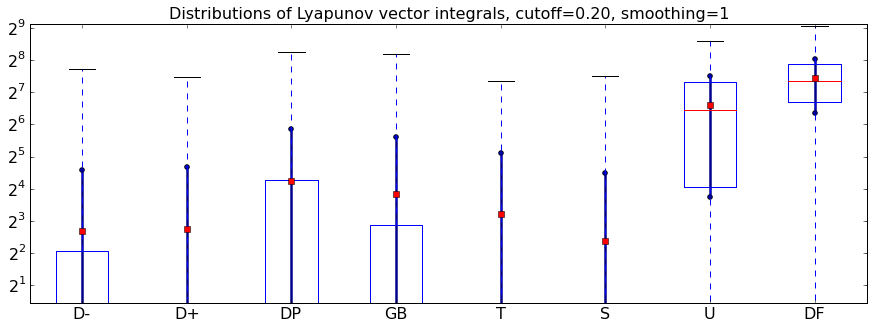

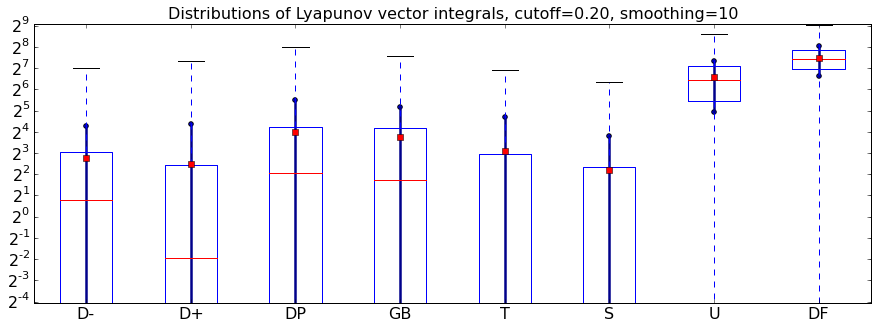

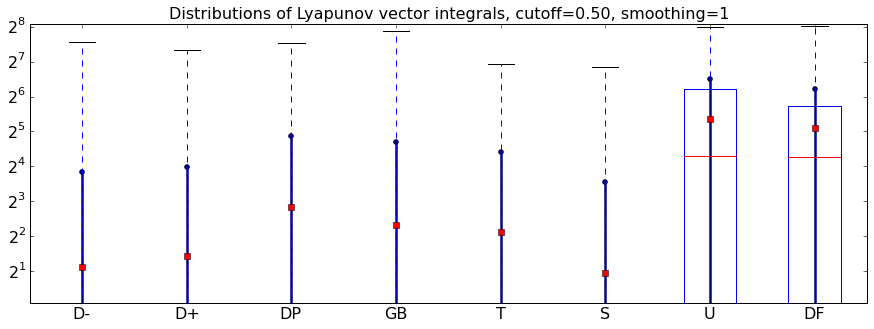

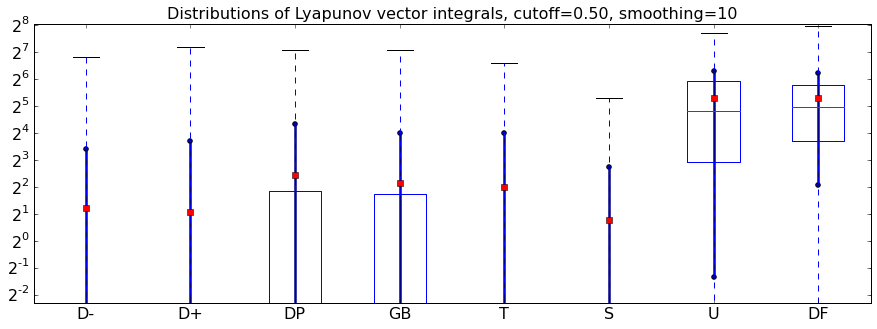

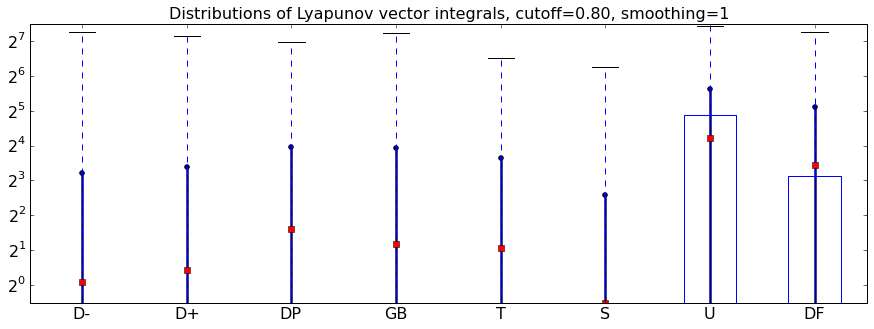

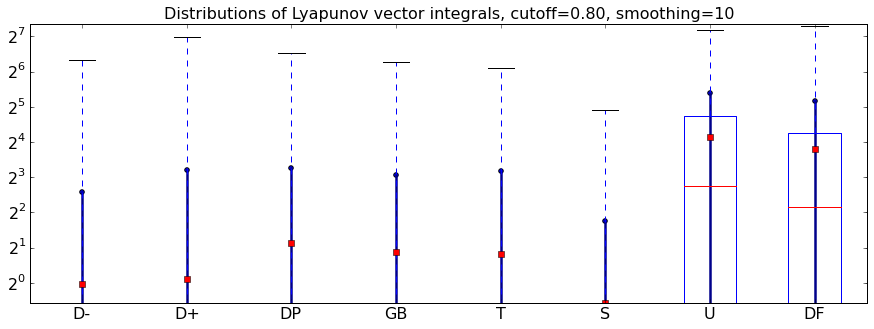

In [9]:
# Generate box plots of integrals

plt.rcParams['figure.figsize'] = (15.0, 5.0);

label_list = ['disclination-concave',
  'disclination-convex',
  'dislocation pair',
  'grain boundary',
  'target',
  'spiral',
  'unclassified',
  'defect-free']

label_abbrev = ['D-', 'D+', 'DP', 'GB', 'T', 'S', 'U', 'DF']

for lyap_cutoff in lyap_cutoffs:
    
    for window in smoothing_windows:
        
        plot_data = np.zeros((len(process_range), len(label_list)))
        
        for i in range(len(label_list)):
            
            plot_data[:,i] = all_lyap_stats[lyap_cutoff][window][label_list[i]]

        plt.title('Distributions of Lyapunov vector integrals, cutoff=%0.2f, smoothing=%d' % (lyap_cutoff, window), fontsize=16)
        
        
        means = np.asarray([np.mean(all_lyap_stats[lyap_cutoff][window][label_list[i]]) for i in range(len(label_list))])
        coeff_var = np.asarray([np.std(all_lyap_stats[lyap_cutoff][window][label_list[i]]) for i in range(len(label_list))])
        lower_estimate = means - coeff_var
        upper_estimate = means + coeff_var
        
        for i in range(len(label_list)):
            plt.plot([i+1,i+1], [lower_estimate[i], upper_estimate[i]], linewidth=2.5, color='darkblue')
        plt.scatter(range(1,len(label_list)+1), lower_estimate)
        plt.scatter(range(1,len(label_list)+1), upper_estimate)
        
        plt.boxplot(plot_data, labels=label_abbrev, showfliers=False, showmeans=True, whis=1000)
        ax = plt.gca()
        ax.set_yscale('log', basey=2)
        plt.setp(ax.get_xticklabels(), fontsize=16)
        plt.setp(ax.get_yticklabels(), fontsize=16)
        plt.ylim([0,np.max(np.max(plot_data))*1.05])
        
        
        plt.show()
    
    